In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy import stats
import copy
import pickle
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import os

In [3]:
model_paths = sorted(os.listdir("../models"))
regression_models = []
cnn_bw_models = []
for elt in model_paths:
    #print(elt[len(elt)-3:len(elt)])
    if elt[len(elt)-6:len(elt)] == "bw.pth":
        cnn_bw_models.append(elt)
    else:
        regression_models.append(elt)
for elt in cnn_bw_models:
    print(elt)
print(len(cnn_bw_models))

resnet18_HHVEHCNT_P_CAP_mean_norm_bw.pth
resnet18_HHVEHCNT_mean_norm_bw.pth
resnet18_TRPTRANS_1_mean_norm_bw.pth
resnet18_TRPTRANS_2_mean_norm_bw.pth
resnet18_TRPTRANS_3_mean_norm_bw.pth
5


In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
def initialize_data(image_type, output_var, output_type, input_var, BE_var, num_categories, size):
    # outputs: randonmized training and testing sets for NHTS, BE, images, and y.
    
    ### read image array
    if image_type == 'rgb':
        image_array_ = np.load("../data_process/image_array_rgb_tract_large.npy", mmap_mode='r')
        image_array = image_array_[:size,]
    elif image_type == 'bw':
        image_array_ = np.load("../data_process/image_array_bw_tract_large.npy", mmap_mode='r')
        image_array = image_array_[:size,]        
    elif image_type == 'merge':
        bw_image_array_ = np.load("../data_process/image_array_bw_tract_large.npy", mmap_mode='r')
        rgb_image_array_ = np.load("../data_process/image_array_rgb_tract_large.npy", mmap_mode='r')
        bw_image_array = bw_image_array_[:size,]
        rgb_image_array = rgb_image_array_[:size,]        
        image_array = np.concatenate([rgb_image_array, bw_image_array], axis=1)
    
    ### create output array
    df_ = pd.read_csv("../data_process/df_merged_tract_large.csv")
    df = df_.iloc[:size,]
    y_ = df[output_var].values 
    # cut y into categories for discrete variables
    if output_type == 'continuous':
        y = copy.deepcopy(y_)
    elif output_type == 'discrete':
        y = np.array(pd.qcut(y_, q = num_categories, labels=np.arange(num_categories))) 
    x = df[input_var]
    BE = df[BE_var]
    census_ids = copy.deepcopy(df["CENSUS_ID"].values)
    ###NO SHUFFLE FOR EPSILON ANALYSIS
    shuffle_idx = np.arange(size)
    train_ratio = 0.8

    ###
    # y
    if output_type == 'discrete':
        y_train = y[shuffle_idx[:int(train_ratio*size)]].astype("int")
        y_test = y[shuffle_idx[int(train_ratio*size):]].astype("int")
    elif output_type == 'continuous':
        y_train = y[shuffle_idx[:int(train_ratio*size)]].astype("float32")
        y_test = y[shuffle_idx[int(train_ratio*size):]].astype("float32")
    # BE
    BE_train = BE.values[shuffle_idx[:int(train_ratio*size)]].astype("float32")
    BE_test = BE.values[shuffle_idx[int(train_ratio*size):]].astype("float32")        
    # image array
    x_train_images = image_array[shuffle_idx[:int(train_ratio*size)],].astype("float32")
    x_test_images = image_array[shuffle_idx[int(train_ratio*size):],].astype("float32")
    # NHTS
    x_train = x.values[shuffle_idx[:int(train_ratio*size)]].astype("float32")
    x_test = x.values[shuffle_idx[int(train_ratio*size):]].astype("float32")
    
    return census_ids, y_train,y_test,BE_train,BE_test,x_train,x_test,x_train_images,x_test_images

In [6]:
def initialize_model(model_name, num_categories, input_channels = 3, use_pretrained=True, full_training=False):
    # initliaze the CNN model.
    # default input image size = 3*224*224, but inputs and output channels can be changed. 
    # num_categories: output channels. For continuous varialbes, use num_categories = 1.
    # return the model

    if model_name == 'resnet18':
        """ resnet 18"""
        model_ft = models.resnet18(pretrained=use_pretrained)
        # train only the last layer.
        for param in model_ft.parameters():
            param.requires_grad=full_training
        if input_channels != 3:
            # Edit the input channels.
            model_ft.conv1 = nn.Conv2d(input_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_categories) # if output_type == continuous, then num_categories = 1.

    elif model_name == 'alexnet':
        """ alexnet """
        model_ft = models.alexnet(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = full_training 
        if input_channels != 3:
            model_ft.features[0] = nn.Conv2d(input_channels, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))    
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_categories) # if output_type == continuous, then num_categories = 1.

    elif model_name == 'vgg':
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = full_training 
        if input_channels != 3:
            model_ft.features[0] = nn.Conv2d(input_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_categories) # if output_type == continuous, then num_categories = 1.

    elif model_name == 'squeezenet':
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = full_training 
        if input_channels != 3:
            model_ft.features[0] = nn.Conv2d(input_channels, 96, kernel_size=(7, 7), stride=(2, 2))
        model_ft.classifier[1] = nn.Conv2d(512, num_categories, kernel_size=(1,1), stride=(1,1))

    elif model_name == 'densenet':
        model_ft = models.densenet121(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = full_training
        if input_channels != 3:
            model_ft.features[0] = nn.Conv2d(input_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_categories)

    elif model_name == 'wide_resnet':
        model_ft = models.wide_resnet50_2(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = full_training 
        if input_channels != 3:
            model_ft.conv1 = nn.Conv2d(input_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_categories)
        
    elif model_name == 'mnasnet':
        model_ft = models.mnasnet1_0(pretrained=use_pretrained)
        for param in model_ft.parameters():
            param.requires_grad = full_training
        if input_channels != 3:
            model_ft.layers[0] = nn.Conv2d(input_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_categories)
        
    return model_ft

In [7]:
input_var=['R_AGE_IMP_mean', 'HHSIZE_mean', 'HHFAMINC_mean', 'HBHTNRNT_mean', 'HBPPOPDN_mean', 'HBRESDN_mean', 
           'R_SEX_IMP_2_mean', 'EDUC_2_mean', 'HH_RACE_2_mean', 'HOMEOWN_1_mean', 'HOMEOWN_2_mean',
           'HBHUR_R_mean', 'HBHUR_S_mean', 'HBHUR_T_mean','HBHUR_U_mean']
BE_var = ['density', 'diversity', 'design']

In [19]:
plots = []

In [24]:
for model_path in cnn_bw_models:
    helper = model_path.split("_")
    output_var = "_".join(helper[1:-1])
    print(output_var)
    
    model = initialize_model(model_name="resnet18", num_categories=1, input_channels=4, use_pretrained=True, full_training=True)
    PATH = "../models/" + model_path
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    census_ids, y_train,y_test,BE_train,BE_test,x_train,x_test,x_train_images,x_test_images = initialize_data(image_type="bw", output_var=output_var, output_type="continuous", input_var=input_var, BE_var=BE_var, num_categories=1, size=18491)
    
    print(x_train_images.shape)
    print(x_test_images.shape)
    x = torch.from_numpy(np.vstack((x_train_images,x_test_images))/255)
    print(x.shape)
    print(y_train.shape)
    print(y_test.shape)
    y = torch.from_numpy(np.append(y_train,y_test))
    print(y.shape)
    print("id", census_ids.shape)
    ds = TensorDataset(x,y)
    dl = DataLoader(ds, batch_size=1, shuffle=False)
    
    y_predicted = np.zeros(y.shape, dtype=np.float32)
    
    i = 0
    with torch.no_grad():
        for inputs, labels in dl:
            single_pred = model(inputs.to(device)).cpu().numpy()
            #print(single_pred)
            #print(type(single_pred[0][0]))
            y_predicted[i] = single_pred[0][0]
            #print(y_predicted[i])
            i += 1
    
    print(y_predicted.shape)
    print("y_predicted", y_predicted)
    
    y_np = np.append(y_train,y_test)
    epsilons = y_np - y_predicted
    original_indices, epsilons_sorted = zip(*sorted(list(zip(np.arange(epsilons.shape[0]), epsilons)), key = lambda x: x[1]))
    plots.append((model_path, original_indices, epsilons_sorted, y_np.tolist(), y_predicted.tolist()))
    
index_to_census_id = {i:id for i, id in enumerate(census_ids)}

HHVEHCNT_P_CAP_mean_norm
(14792, 4, 224, 224)
(3699, 4, 224, 224)
torch.Size([18491, 4, 224, 224])
(14792,)
(3699,)
torch.Size([18491])
id (18491,)
(18491,)
y_predicted [ 0.10347274 -0.00832456  0.01579168 ...  0.00884792 -0.07880765
  0.01522091]
HHVEHCNT_mean_norm
(14792, 4, 224, 224)
(3699, 4, 224, 224)
torch.Size([18491, 4, 224, 224])
(14792,)
(3699,)
torch.Size([18491])
id (18491,)
(18491,)
y_predicted [-0.05530985 -0.0444923  -0.17057519 ... -0.1280205  -0.12990178
 -0.11192419]
TRPTRANS_1_mean_norm
(14792, 4, 224, 224)
(3699, 4, 224, 224)
torch.Size([18491, 4, 224, 224])
(14792,)
(3699,)
torch.Size([18491])
id (18491,)
(18491,)
y_predicted [ 0.03320731  0.11417443  0.06154102 ...  0.18473762 -0.01867423
  0.09814806]
TRPTRANS_2_mean_norm
(14792, 4, 224, 224)
(3699, 4, 224, 224)
torch.Size([18491, 4, 224, 224])
(14792,)
(3699,)
torch.Size([18491])
id (18491,)
(18491,)
y_predicted [-0.12740529 -0.11383015 -0.06681132 ... -0.13502109 -0.12793456
 -0.14899813]
TRPTRANS_3_mean_norm
(

In [26]:
percentile0_25_census_id_list = []
percentile75_100_census_id_list = []

resnet18_HHVEHCNT_P_CAP_mean_norm_bw.pth


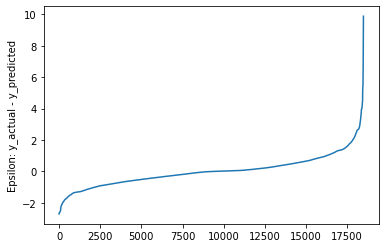

resnet18_HHVEHCNT_mean_norm_bw.pth


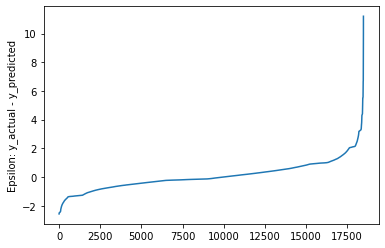

resnet18_TRPTRANS_1_mean_norm_bw.pth


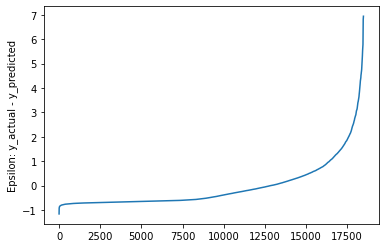

resnet18_TRPTRANS_2_mean_norm_bw.pth


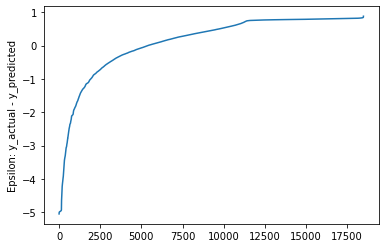

resnet18_TRPTRANS_3_mean_norm_bw.pth


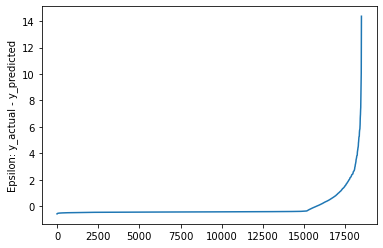

In [27]:
for plot in plots:
    model_path, original_indices, epsilons_sorted, y, y_predicted = plot
    print(model_path)
    plt.clf()
    plt.plot(epsilons_sorted)
    plt.ylabel("Epsilon: y_actual - y_predicted")
    plt.show()
    n = len(epsilons_sorted)
    percentile0_25 = original_indices[:n//4]
    percentile75_100 = original_indices[(3*n)//4:]
    
    percentile0_25_census_ids = [index_to_census_id[i] for i in percentile0_25]
    percentile75_100_census_ids = [index_to_census_id[i] for i in percentile75_100]
    percentile0_25_census_id_list.append((model_path, percentile0_25_census_ids))
    percentile75_100_census_id_list.append((model_path,percentile75_100_census_ids))
    

In [28]:
with open('../outputs/percentile0_25_census_id_cnn_bw_list.pickle', 'wb') as h:
    pickle.dump(percentile0_25_census_id_list, h, protocol=pickle.HIGHEST_PROTOCOL)

with open('../outputs/percentile75_100_census_id_cnn_bw_list.pickle', 'wb') as h:
    pickle.dump(percentile75_100_census_id_list, h, protocol=pickle.HIGHEST_PROTOCOL)

resnet18_HHVEHCNT_P_CAP_mean_norm_bw.pth


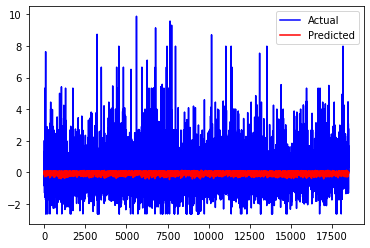

resnet18_HHVEHCNT_mean_norm_bw.pth


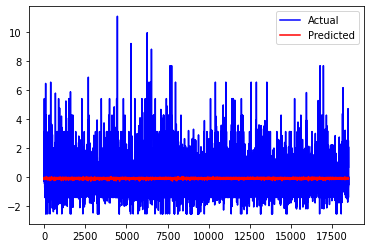

resnet18_TRPTRANS_1_mean_norm_bw.pth


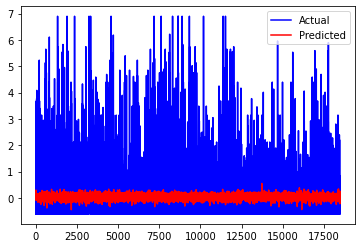

resnet18_TRPTRANS_2_mean_norm_bw.pth


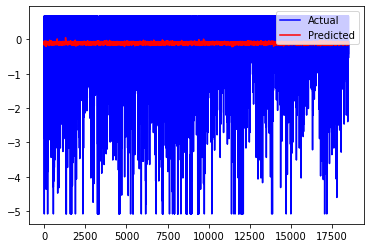

resnet18_TRPTRANS_3_mean_norm_bw.pth


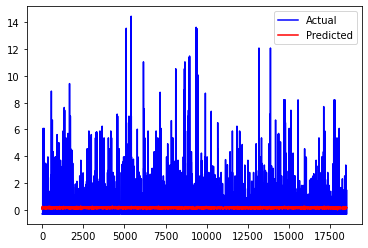

In [29]:
for plot in plots:
    model_path, original_indices, epsilons_sorted, y, y_predicted = plot
    print(model_path)
    plt.clf()
    plt.plot(y, 'b', label="Actual")
    plt.plot(y_predicted, 'r', label="Predicted")
    plt.legend(loc="upper right")
    plt.show()